This notebook contains code to reproduce the multi-fidelity neural network function approximation results from Meng and Karniadakis 2019. 

In [63]:
''' Magics '''
%matplotlib notebook

''' Relevant imports '''
import torch
import math
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

In [178]:
class MFNN(nn.Module):
    ''' Multi-fidelity neural network (Meng and Karniadakis 2019): 
        - nn_l: a neural network which generates predictions of the low-fidelity data
        - nn_h1: a neural network which computes linear correlation between the low- and high-fidelity data 
        - nn_h2: a neural network which computes nonlinear correlation between the low- and high-fidelity data '''
    
    def __init__(self, nn_l, nn_h1, nn_h2, use_yl2=False, tau=None):
        super(MFNN, self).__init__()
        self.nn_l = nn_l 
        self.nn_h1 = nn_h1
        self.nn_h2 = nn_h2 
        self.use_yl2 = use_yl2
        self.tau=tau

    def forward(self, x):
        # Compute low-fidelity prediction (y_l) via nn_l. 
        y_l = self.nn_l(x)
        if self.use_yl2 and self.tau: 
            y_l2 = self.nn_l(x-self.tau)
        # Compute linear and nonlinear correlations (F_l, F_nl) via nn_h1 and nn_h2. 
        if self.use_yl2 and self.tau: 
            F_l = self.nn_h1(torch.cat((x, y_l), 1))
            F_nl = self.nn_h2(torch.cat((x, y_l, y_l2), 1))
        else: 
            F_l = self.nn_h1(torch.cat((x, y_l), 1))
            F_nl = self.nn_h2(torch.cat((x, y_l), 1))
        # Compute multi-fidelity prediction (h_1) from F_l and F_nl.
        y_h = F_l + F_nl
        return torch.cat((y_l, y_h), 1)

In [4]:
class FNN(nn.Module):
    '''Fully-connected neural network implementation (FNN): 
       - layer_sizes: the sizes of the layers from input to output layer 
       - activation (optional; default False): whether or not to use activation functions in this FNN. '''
    
    def __init__(self, layer_sizes, activation=True):
        super(FNN, self).__init__()
        # Create a list of linear layer modules of the specified sizes.  
        self.linear_layers = nn.ModuleList()
        self.activation = activation 
        for i in range(1, len(layer_sizes)): 
            self.linear_layers.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            # Override default Lecun initialization to use Xavier's initialization method instead 
            nn.init.xavier_normal_(self.linear_layers[-1].weight)
    
    def forward(self, x):
        # Iterate through linear layers. 
        for linear_layer in self.linear_layers[:-1]: 
            # Apply activation to hidden layers if needed. 
            if self.activation: 
                x = torch.tanh(linear_layer(x))
            else: 
                x = linear_layer(x)
        # Don't use activation for last layer. 
        x = self.linear_layers[-1](x)
        return x

In [220]:
def train_MFNN(
    module, 
    num_epochs, 
    lr, 
    l2_lambda_h2, 
    train_data, 
    num_low, 
    num_high, 
    grad_low_fi=None, 
    l2_lambda_l=0, 
    verbose=False,
    p=2
): 
    ''' Runs end-to-end training for multi-fidelity neural network.
        - module: the torch module (i.e., neural network) to train 
        - num_epochs: number of epochs to train 
        - lr: learning rate
        - l2_lambda_h2: regularization rate for NNH2 
        - num_low: number of low-fidelity training data 
        - num_high: number of high-fidelity training data 
        - grad_low_fi (optional; default None): exact gradient of low-fidelity function, if available
        - l2_lambda_l (optional; default false): regularization rate for NNL
        - verbose (optiona; default False): whether to print information such as the current loss 
          periodically during training. '''
    
    # Set up optimizer. 
    optimizer = optim.LBFGS(module.parameters(), lr=lr)
    
    # Store inputs and targets, and gradients of low-fidelity function if available. 
    (inputs, targets) = (torch.narrow(train_data, 1, 0, 1), torch.narrow(train_data, 1, 1, 1))
    inputs.requires_grad = True 
    if grad_low_fi:
        GT_l = grad_low_fi(inputs[:][:num_low])
    losses = []

    # Define the loss criterion. 
    def loss_MFNN(preds, targets, inputs, print_grad=False):
        '''MSE loss calculation as specified in Meng and Karniadakis 2019'''
        
        # For low-fidelity train data, use low-fidelity prediction from nn_l. For high-fidelity train data,
        # use high-fidelity prediction from nn_h1 and nn_h2.
        Y_l = torch.narrow(torch.narrow(preds, 0, 0, num_low), 1, 0, 1)
        Y_h = torch.narrow(torch.narrow(preds, 0, num_low, num_high), 1, 1, 1)
        T_l, T_h = targets[:num_low], targets[num_low:]
        
        if grad_low_fi: 
            # Compute gradient penalty
            GY_l = torch.empty(size=(num_low, 1))
            for i in range(num_low): 
                x = inputs[:][i]
                y = module.nn_l(x)
                gyl = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
                GY_l[i] = gyl
            if print_grad: 
                print(GY_l, flush=True)

        # Compute MSE terms from low_fidelity and high-fidelity contribution.
        if grad_low_fi: 
            MSE_l = torch.mean((Y_l - T_l)**2 + (GY_l[:][:num_low] - GT_l)**2)
        else: 
            MSE_l = torch.mean((Y_l - T_l)**2)
        MSE_h = torch.mean((Y_h - T_h)**2)  
        
        # Compute L2 regularization term from nn_l and nn_h2 parameters. Only penalize for size of weights 
        # (not biases). 
        l2_reg_l = torch.tensor(0., requires_grad=True)
        l2_reg_h2 = torch.tensor(0., requires_grad=True)
        for (name, param) in module.nn_l.named_parameters():
            if 'weight' in name: 
                l2_reg_l = l2_reg_l + torch.norm(param, p=p)**p
        for (name, param) in module.nn_h2.named_parameters(): 
            if 'weight' in name: 
                l2_reg_h2 = l2_reg_h2 + torch.norm(param, p=p)**p
        
        # Compute and return loss. 
        loss = MSE_l + MSE_h + l2_lambda_l*l2_reg_l + l2_lambda_h2*l2_reg_h2
        return loss
    
    # Define the closure to update weights in each epoch. 
    def closure(): 
        optimizer.zero_grad()
        preds = module(inputs)
        loss = loss_MFNN(preds, targets, inputs)
        loss.backward(retain_graph = True)
        return loss 
    
    # Loop for specified number of epochs. 
    for epoch in tqdm(range(num_epochs)): 
        optimizer.step(closure)                                 # step optimizer
        preds = module(inputs)                                  # compute new predictions
        losses.append(loss_MFNN(preds, targets, inputs).item()) # record loss
        if verbose and epoch % 100 == 0:
            loss_MFNN(preds, targets, inputs, print_grad=True).item()
    
    return losses
        

In [179]:
def setup_training(
    low_fi, 
    high_fi, 
    nn_l_layers, 
    nn_h1_layers, 
    nn_h2_layers, 
    low_pts, 
    high_pts, 
    nn_h_layers = None,
    use_yl2 = False, 
    tau = None,
): 
    '''Sets up model for training by formatting training data appropriately. 
       - low_fi: low-fidelity function handle 
       - high_fi: high-fidelity function handle 
       - nn_l_layers: list containing number of neurons per layer for NNL
       - nn_h2_layers: list containing number of neurons per layer for NNH2 
       - low_pts: low-fidelity training data input points 
       - high_pts: high-fidelity training data input points
       - nn_h_layers (default None): list containing number of neurons per layer for a FNN trained on high-fidelity
         data only (with no low-fidelity input for comparison. '''
    
    # Format train data.
    inputs = torch.transpose(torch.tensor([low_pts+high_pts]), 0, 1)
    num_low = len(low_pts)
    num_high = len(high_pts)
    low = low_fi(inputs[:][:num_low])
    high = high_fi(inputs[:][num_low:])
    train_data = torch.cat((inputs, torch.cat((low, high))), 1)

    # Initialize model.
    if nn_l_layers: 
        nn_l = FNN(nn_l_layers)
    if nn_h1_layers: 
        nn_h1 = FNN(nn_h1_layers, activation=False)         # no activations for NN_H1 
    if nn_h2_layers: 
        nn_h2 = FNN(nn_h2_layers)
    nn_mfl = MFNN(nn_l, nn_h1, nn_h2, use_yl2=use_yl2, tau=tau)
    
    # Initialize and return all information for training including the initialized model. Also include a 
    # newly initialized high-fidelity model, if specified in the inputs.
    if nn_h_layers: 
        nn_hfl = FNN(nn_h_layers)
        return (nn_mfl, nn_hfl, hfl, train_data, num_low, num_high)
    return (nn_mfl, train_data, num_low, num_high)


In [157]:
'''Generates plots for a given experiment. Provide: 
   - nn_mfl: the (trained) model 
   - train_data: the training data used  
   - num_low: number of low_fidelity data points used 
   - high_fi: a function to compute exact high-fidelity function value, given x
   - low_fi: a function to compute exact low-fidelity function value, given x
   - mesh_size (optional): how fine a mesh to use for plotting the exact and approximate functions. 
   - range_loss_plot (optional): lower bound of range for plotting loss vs epochs
'''
def generate_plots(
    nn_mfl, 
    train_data, 
    num_low, 
    high_fi, 
    low_fi, 
    losses, 
    mesh_size=1000, 
    range_loss_plot=None): 
    
    plt.subplots(figsize=(10,8))
    
    '''Plot the data (a) in paper. Plots training data as well as exact low- and high-fidelity functions.'''
    ax1 = plt.subplot(2, 2, 1)
    x_test = torch.linspace(0, 1, mesh_size).view(mesh_size, 1)
    y_l = low_fi(x_test)
    y_h = high_fi(x_test)
    ax1.plot(x_test, y_h, 'k', linewidth=2)
    ax1.plot(x_test, y_l, 'grey', linewidth=2)
    inputs = torch.narrow(train_data, 1, 0, 1)
    ax1.plot(inputs[:][:num_low], low_fi(inputs[:][:num_low]), 'bo', linewidth=5, markersize=8)
    ax1.plot(inputs[:][num_low:], high_fi(inputs[:][num_low:]), 'rx', linewidth=5, markersize=8, mew=2)
    ax1.set_xlabel("x")

    '''Plot the approximation (c) in paper. Plots exact and approximate low- and high-fidelity functions.'''
    ax2 = plt.subplot(2, 2, 2)
    preds = nn_mfl(x_test)
    x_test = torch.linspace(0, 1, mesh_size).view(mesh_size, 1)
    ax2.plot(x_test, y_h, 'k', linewidth=2)
    ax2.plot(x_test, y_l, 'grey', linewidth=2)
    ax2.plot(x_test, torch.narrow(preds, 1, 0, 1).detach().numpy(), 'b--', linewidth=2)
    ax2.plot(x_test, torch.narrow(preds, 1, 1, 1).detach().numpy(), 'r--', linewidth=2)
    ax2.set_xlabel("x")
#     ax2.set_xlim(0, 1)  
#     ax2.set_ylim(-1.5, 0) 
    
    '''Plot the correlations (d) in paper'''
    ax3 = plt.subplot(2, 2, 3, projection='3d')
    ax3.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.grid(False)
    ax3.plot(
        y_h.view(mesh_size).numpy(),
        y_l.view(mesh_size).numpy(), 
        x_test.view(mesh_size).numpy(),
        'k', 
        linewidth=2
    )
    ax3.plot(
        torch.narrow(preds, 1, 1, 1).detach().view(mesh_size).numpy(),
        torch.narrow(preds, 1, 0, 1).detach().view(mesh_size).numpy(), 
        x_test.view(mesh_size).numpy(),
        'r--',
        linewidth=2
    )
    ax3.plot(
        y_h.view(mesh_size).numpy(),
        y_l.view(mesh_size).numpy(), 
        np.zeros(mesh_size),
        'grey',
        linewidth=2
    )
    ax3.plot(
        torch.narrow(preds, 1, 1, 1).detach().view(mesh_size).numpy(),
        torch.narrow(preds, 1, 0, 1).detach().view(mesh_size).numpy(), 
        np.zeros(mesh_size),
        'b--',
        linewidth=2
    )
    ax3.set_xlabel("y_h")
    ax3.set_xlim(20, -20)  
    ax3.set_ylabel("y_l")
    ax3.set_ylim(-10, 10) 
    ax3.set_zlabel("x")
    ax3.set_zlim(0, 1)
    
    '''Plot the losses.'''
    ax4 = plt.subplot(2, 2, 4)
    if not range_loss_plot: 
        ax4.plot(range(len(losses)), losses)
    else: 
        ax4.plot(range(len(losses))[range_loss_plot:-1], losses[range_loss_plot:-1])
    ax4.set_xlabel("epoch")
    ax4.set_xlabel("loss")

In [233]:
''' EXAMPLE 1: Continuous function example. '''

def low_fi(x, A=.5, B=10, C=-5): 
    return A*(6*x-2)**2 * torch.sin(12*x-4) + B*(x-0.5) + C

def high_fi(x, A=.5, B=10, C=-5): 
    return (6*x-2)**2 * torch.sin(12*x-4)

def grad_low_fi(x, A=.5, B=10, C=-5): 
    return 6*torch.sin(12*x-4) + (72*x - 24)*torch.cos(12*x-4) + 10

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 1], 
    [2, 1], 
    [2, 10, 10, 1], 
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    [0, 0.4, 0.6, 1]
)

# Define training parameters and run training loop.
num_epochs = 8000
lr = .001
l2_lambda_h2 = .1
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2, 
    train_data, 
    num_low, 
    num_high, 
    grad_low_fi=grad_low_fi
)

100%|██████████| 1200/1200 [00:58<00:00, 20.54it/s]


<IPython.core.display.Javascript object>


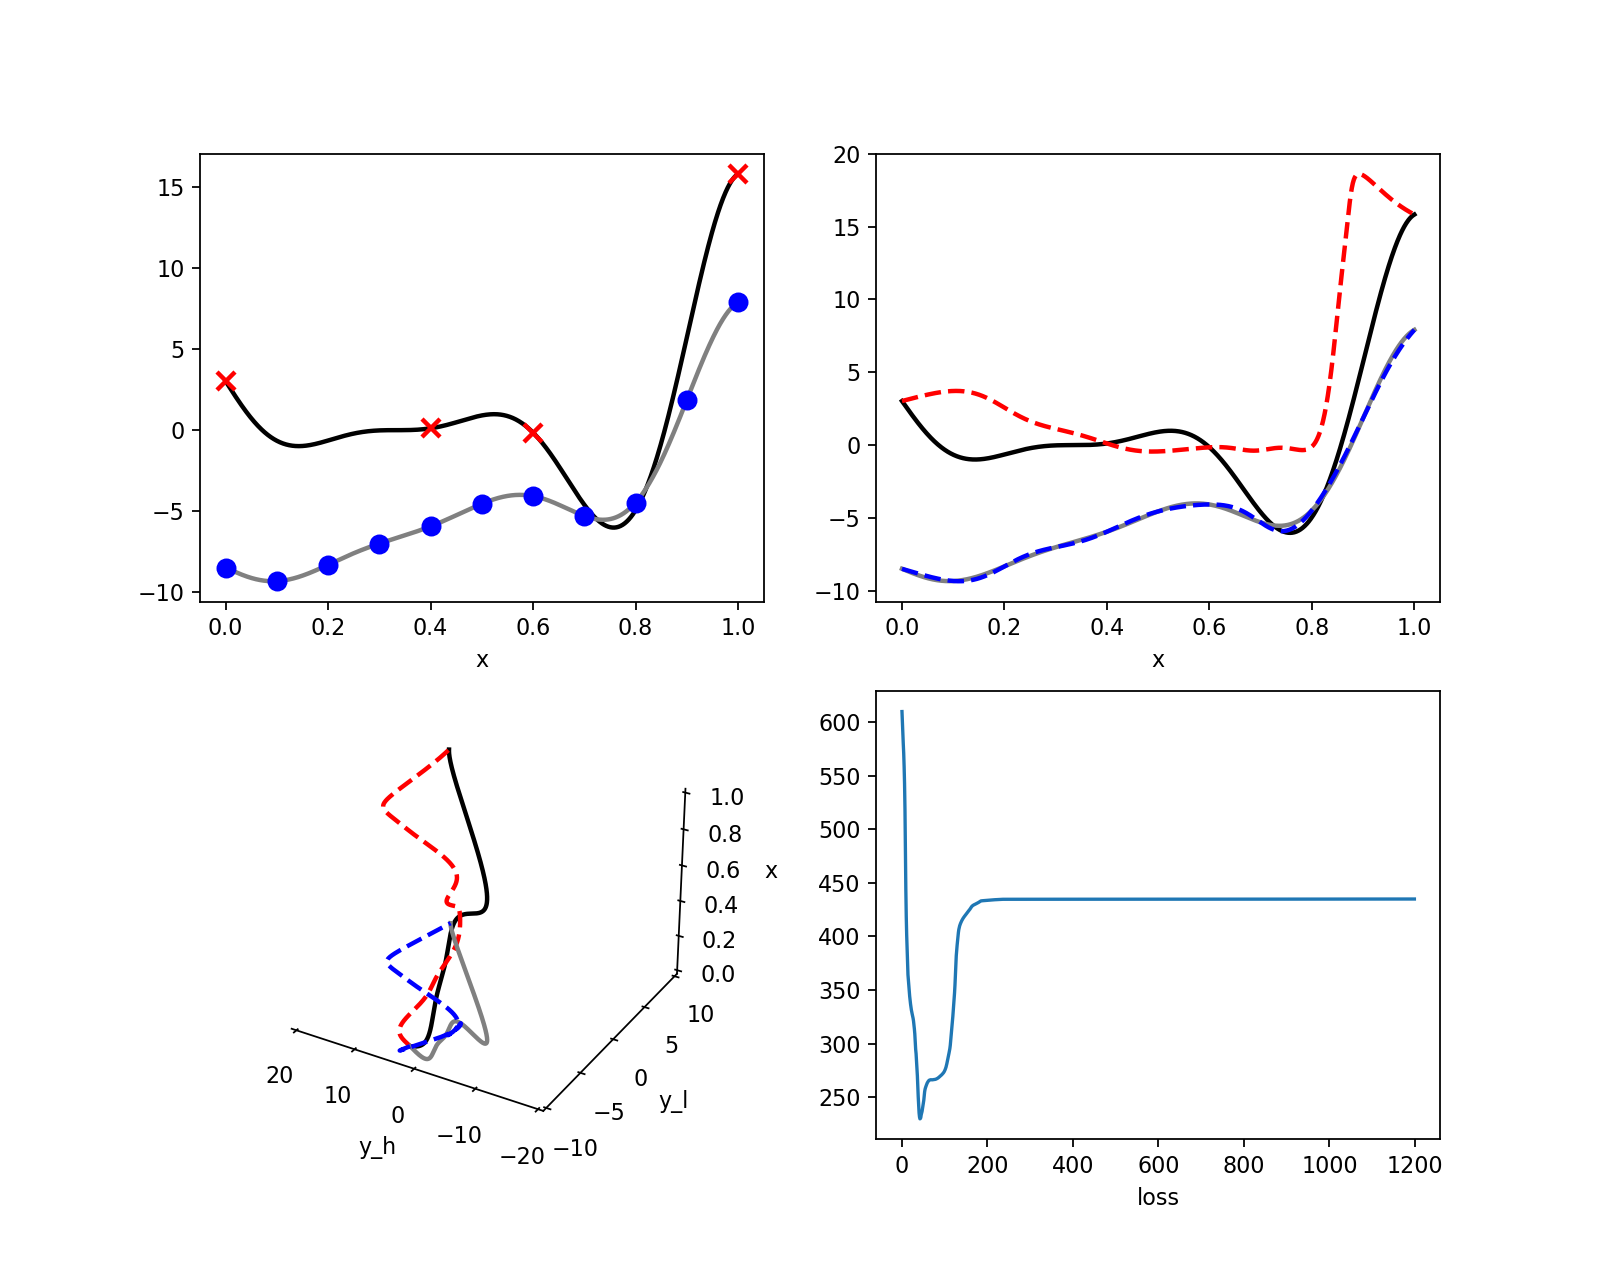

In [234]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=1000)

In [263]:
''' EXAMPLE 2: Discontinuous function example. '''
def low_fi(x): 
    small = 0.5*((6*x-2)**2)*torch.sin(12*x-4) + 10*(x-0.5)-5
    big = 3 + 0.5*((6*x-2)**2)*torch.sin(12*x-4) + 10*(x-0.5)-5
    return torch.where((x >= 0) & (x <= .5), small, big)   

def high_fi(x): 
    small = 2*low_fi(x) - 20*x + 20
    big = 4 + 2*low_fi(x) - 20*x + 20
    return torch.where((x >= 0) & (x <= .5), small, big)

def grad_low_fi(x): 
    small = 216*((1/3 - x)**2)*torch.cos(12*x-4) - (12-36*x)*torch.sin(12*x-4) + 10
    big = 216*((1/3 - x)**2)*torch.cos(12*x-4) - (12-36*x)*torch.sin(12*x-4) + 10
    return torch.where((x >= 0) & (x <= .5), small, big)

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 20, 20, 1], 
    [2, 1], 
    [2, 10, 10, 1], 
    np.linspace(0, .4, 8).tolist()+np.linspace(.4, .6, 22).tolist()+np.linspace(.6, 1, 8).tolist(), 
    [0.2, 0.4, 0.6, 0.75, 0.9]
)

# Define training parameters and run training loop.
num_epochs = 2000
lr = .001
l2_lambda_h2 = .02
l2_lambda_l = .0018
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2,
    train_data,
    num_low, 
    num_high,
    l2_lambda_l=l2_lambda_l,
    grad_low_fi=grad_low_fi,
    p=2,
)

100%|██████████| 2000/2000 [12:18<00:00,  2.71it/s]


<IPython.core.display.Javascript object>


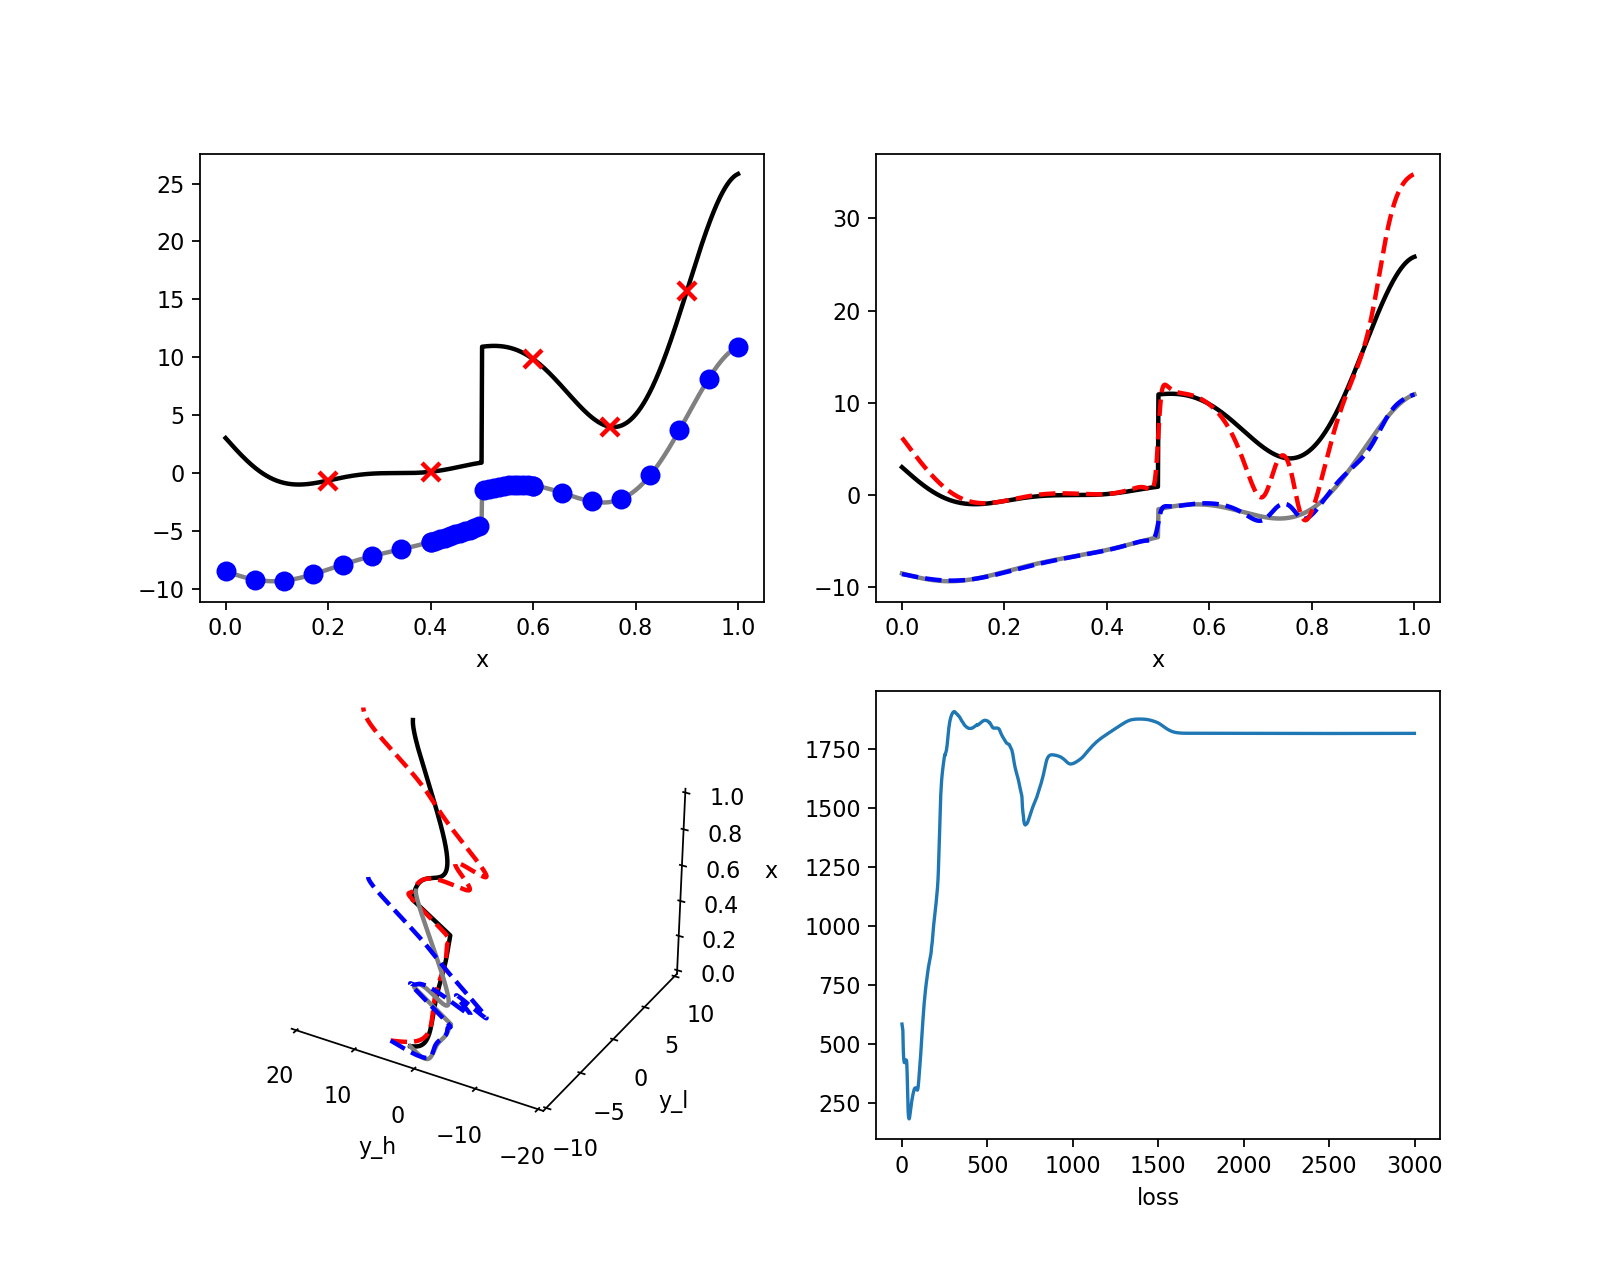

In [239]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=1000)

In [216]:
''' EXAMPLE 3: Continuous function with nonlinear correlation example. '''
def low_fi(x): 
    return torch.sin(8*math.pi*x)

def high_fi(x): 
    return (x-math.sqrt(2))*low_fi(x)*low_fi(x)

def grad_low_fi(x): 
    return torch.cos(8*math.pi*x)*8*math.pi

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 20, 20, 1], 
    [2, 1], 
    [2, 10, 10, 1], 
    np.linspace(0, 1, 51).tolist(), 
    np.arange(0, 1, step=.075).tolist(),
)

# Define training parameters and run training loop.
num_epochs = 1000
lr = .001
l2_lambda_h2 = .00029
l2_lambda_l = 0.0001
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2,
    train_data,
    num_low, 
    num_high,
    l2_lambda_l=l2_lambda_l,
    grad_low_fi=grad_low_fi,
)

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


<IPython.core.display.Javascript object>


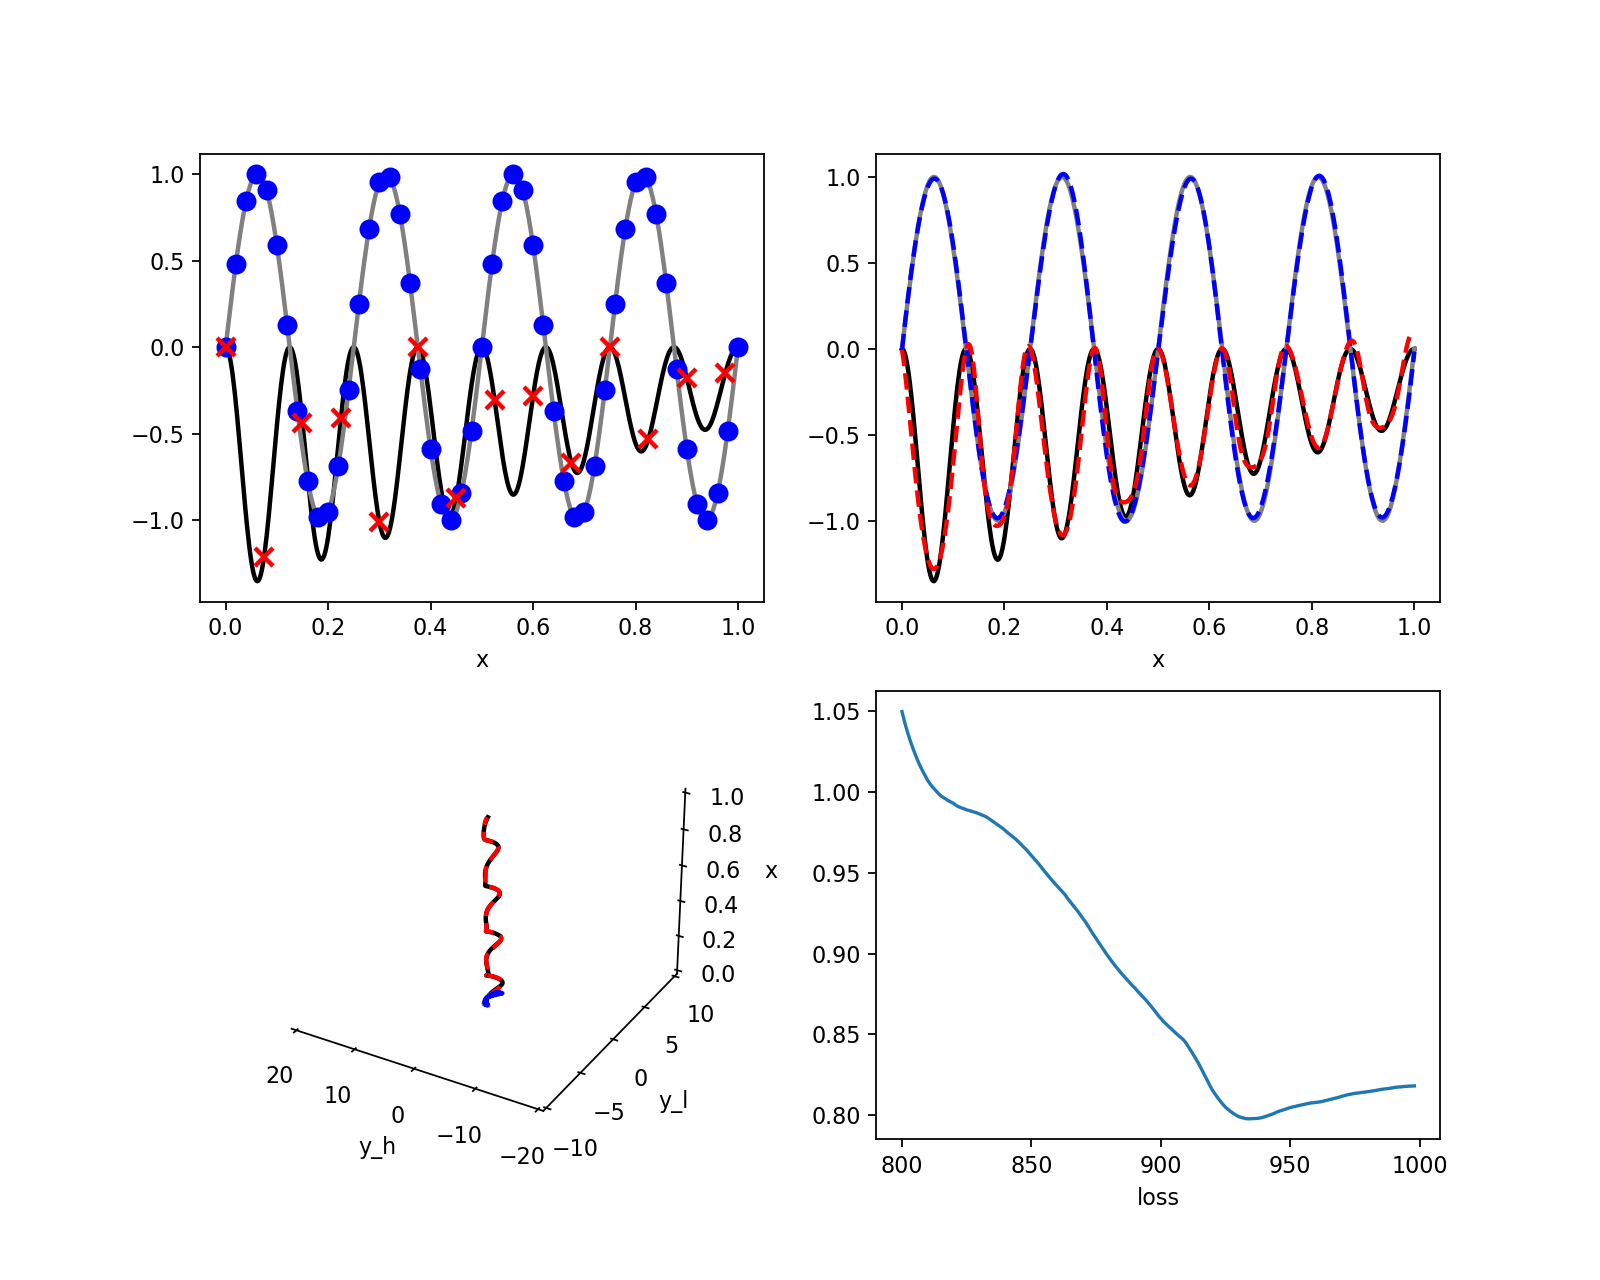

In [217]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=500, range_loss_plot=800)

In [215]:
''' EXAMPLE 4: Continuous function with phase shift and highly nonlinear correlation example. '''
def low_fi(x): 
    return torch.sin(8*math.pi*x)

def high_fi(x): 
    return x**2+(torch.sin(8*math.pi*x + math.pi/10))**2

def grad_low_fi(x): 
    return torch.sin(8*math.pi*x)

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 20, 20, 1], 
    [2, 1], 
    [3, 10, 10, 1], 
    np.linspace(0, 1, 51).tolist(), 
    np.linspace(0, 1, 16).tolist(),
    use_yl2=True, 
    tau=.0449,
)

# Define training parameters and run training loop.
num_epochs = 1000
lr = .001
l2_lambda_h2 = .004
l2_lambda_l = 0
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2,
    train_data,
    num_low, 
    num_high,
    l2_lambda_l=l2_lambda_l,
    grad_low_fi=grad_low_fi,
)

  1%|          | 12/1000 [00:05<07:59,  2.06it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


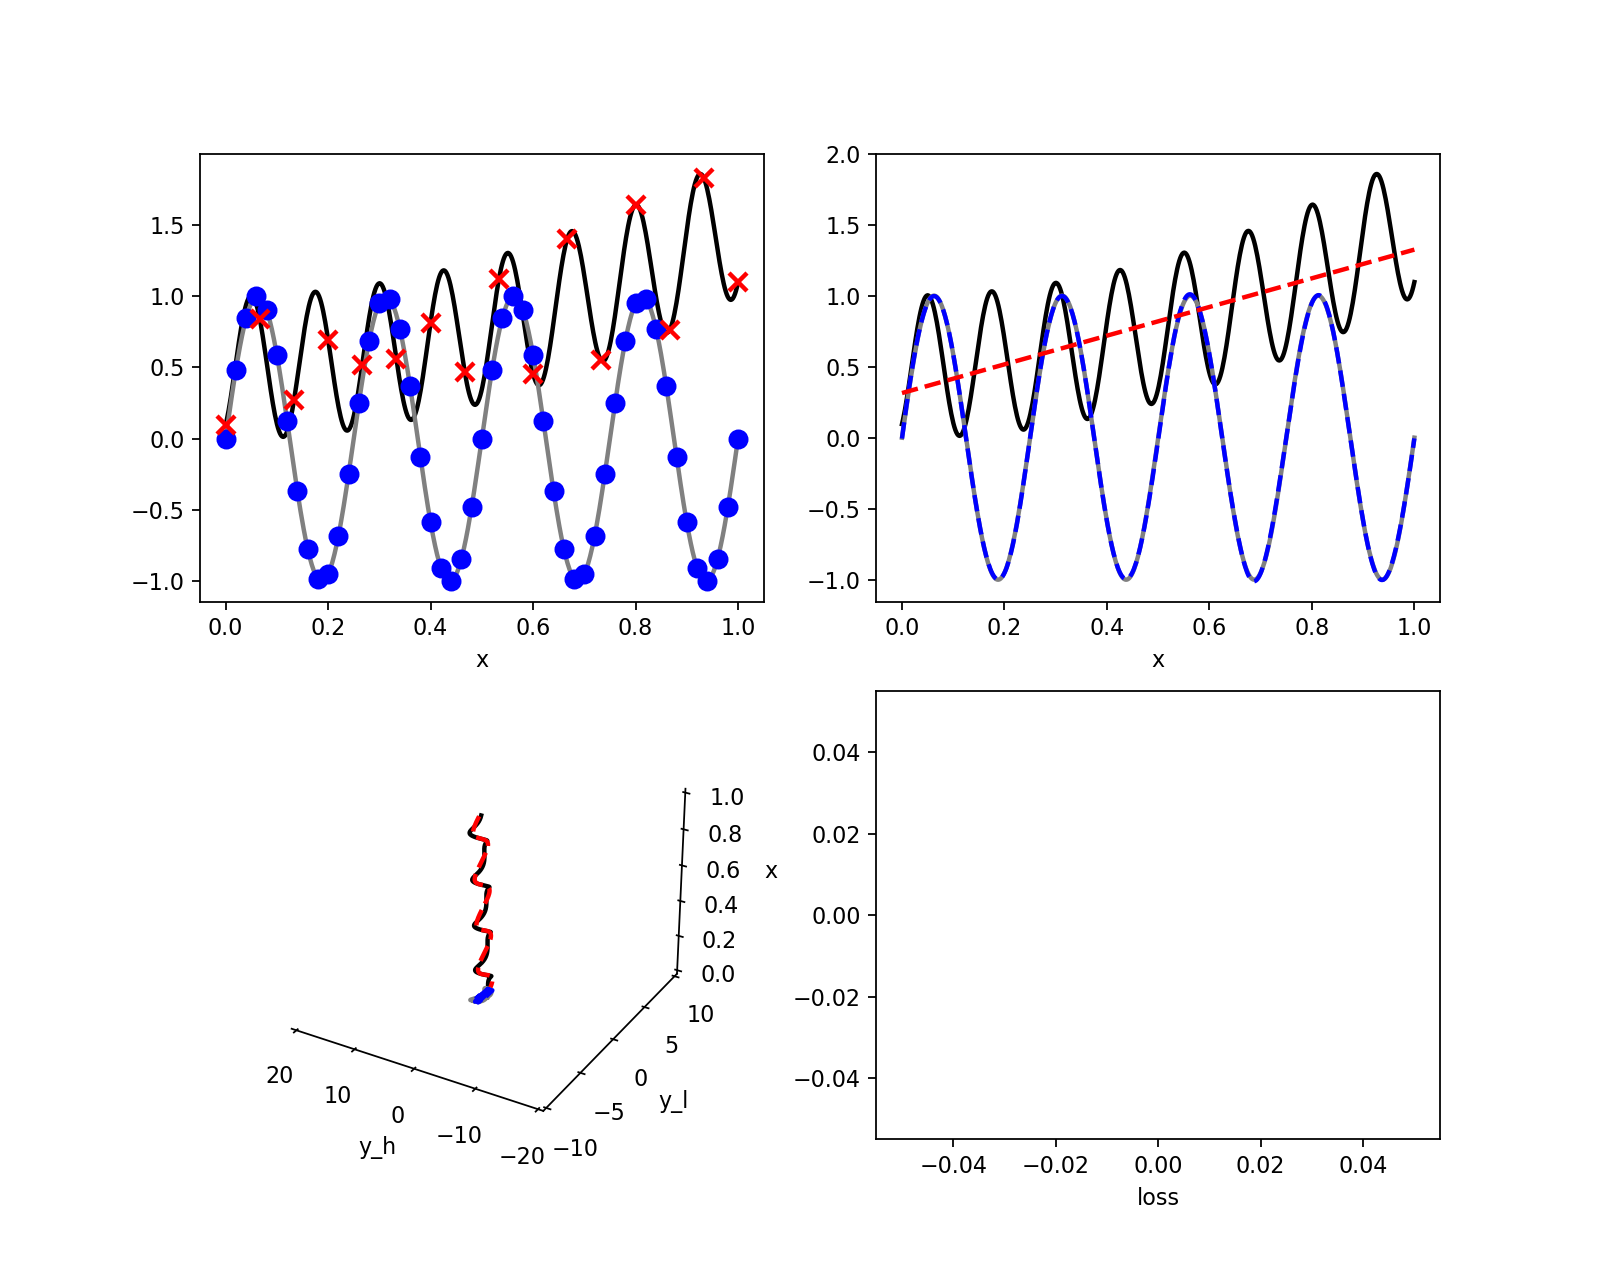

In [214]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, losses, mesh_size=500, range_loss_plot=1000)

In [ ]:
''' EXAMPLE 5: 20-dimensional function example. '''
def hi_fi(x): 
    temp = torch.empty(size=(x.shape[0], 1))
    for i in range(x.shape[0]): 
        sum_val = 0 
        for j in range(2, 5): 
            sum_val += sum_val + (2*(x[i][j])**2 - x[i][j-1])**2
        temp[i] = (x[i][1]-1)**2 + sum_val
    return temp

def low_fi(x): 
    def low_fi(x): 
        temp = torch.empty(size=(x.shape[0], 1))
        for i in range(x.shape[0]): 
            sum_val = 0 
            for j in range(2, 5): 
                sum_val += sum_val + (2*(x[i][j])**2 - x[i][j-1])**2
            temp[i] = (x[i][1]-1)**2 + sum_val
        return temp

def grad_low_fi(x): 
    return torch.sin(8*math.pi*x)

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 20, 20, 1], 
    [2, 1], 
    [3, 10, 10, 1], 
    np.linspace(0, 1, 51).tolist(), 
    np.linspace(0, 1, 16).tolist(),
    use_yl2=True, 
    tau=.0449,
)

# Define training parameters and run training loop.
num_epochs = 1000
lr = .001
l2_lambda_h2 = .001
l2_lambda_l = 0
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda_h2,
    train_data,
    num_low, 
    num_high,
    l2_lambda_l=l2_lambda_l,
    grad_low_fi=grad_low_fi,
)

In [242]:
tensor = torch.tensor([[1,2,3,4,5,1,24,4,5,6,7,8], [5,2,3,4,5,1,24,4,5,6,7,8]])

In [245]:
tensor[0]

tensor([ 1,  2,  3,  4,  5,  1, 24,  4,  5,  6,  7,  8])

In [261]:
def low_fi(x): 
    temp = torch.empty(size=(x.shape[0], 1))
    for i in range(x.shape[0]): 
        sum_val = 0 
        for j in range(2, 5): 
            sum_val += sum_val + (2*(x[i][j])**2 - x[i][j-1])**2
        temp[i] = (x[i][1]-1)**2 + sum_val
    return temp
y = low_fi(tensor)

In [262]:
y

tensor([[4954.],
        [4823.]])

In [253]:
tensor.shape[0]

2

In [254]:
tensor[0][1] = 1

In [257]:
t = torch.empty(size=(3, 1))

In [258]:
t[1] = 1

In [259]:
t

tensor([[ 0.0000e+00],
        [ 1.0000e+00],
        [-1.4948e+07]])

In [260]:
for j in range(2, 21): 
    print(j)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
